<a href="https://colab.research.google.com/github/ivenaf/DataScience_Bootcamp_Notebooks/blob/main/127_5_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series: Analysis and Predictions
## Prophet
### I. Introduction
This last notebook is dedicated to Prophet. Prophet is an open-source library developed by Facebook, specifically designed for time series forecasting. It is particularly effective for series with non-linear trends and pronounced seasonal effects. Prophet works by using an additive model that decomposes the series into several components (trend, seasonality, special days), which makes the tool intuitive and simple to configure.

With Prophet, users can easily adjust forecasts by taking into account uncertainty and series particularities, such as holidays. Additionally, it is robust to outliers and missing data, making it a very practical and flexible tool for users of different expertise levels.

### II. Data Import
In this notebook, we will continue working with the Air Passengers time series used in previous notebooks.

(a) Execute the following cell to import the packages necessary for the exercise.

In [15]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

(b) Store in a DataFrame df the content of the file AirPassengers.csv by adding the argument parse_dates=True to automatically convert the Month column to datetime format.

(c) Display the first 5 lines of the dataframe.

In [16]:

df = pd.read_csv('AirPassengers.csv', parse_dates=True)
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


### III. Data Preparation

We will now prepare the data to use it with Prophet.

**Warning**, the input data for the model created by Prophet is a dataframe with 2 columns: ds and y. The ds (datestamp) column must be in a datetime format, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric and represents the series we want to predict.

(d) Rename the columns of the dataframe so they are properly named for use with Prophet.

In [17]:
df = df.rename(columns={"Month": "ds", "#Passengers": "y"})
df.head()

,ds,y
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


(e) Split the data into training and test sets, keeping only the last 24 months of data in the test set.

In [18]:
df_train = df.iloc[:-24]
df_test = df.iloc[-24:]

### IV. Modeling

The dataset is now ready to be used to train a model created by Prophet.

(f) Initialize a Prophet model then fit this model on the training dataset.

In [19]:
model = Prophet()
model.fit(df_train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3z5do1k/p6_ibrd5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3z5do1k/htomcj8t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30000', 'data', 'file=/tmp/tmpx3z5do1k/p6_ibrd5.json', 'init=/tmp/tmpx3z5do1k/htomcj8t.json', 'output', 'file=/tmp/tmpx3z5do1k/prophet_modelw800c6vy/prophet_model-20250403135258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:52:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:52:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Predictions are made on a dataframe where the ds column contains the dates for which a prediction must be made. You can obtain an appropriate dataframe that extends into the future for a specified number of days using Prophet's make_future_dataframe method. By default, this dataframe will also include the dates from the training data, which will also allow you to see how the model fits the data.

(g) Create the **future** dataframe that contains the dates for predictions to be made.


In [20]:
future = model.make_future_dataframe(periods=24, freq = 'ME')
future.tail()

# ou future = df_test[["ds"]]

,ds
139,1960-07-31
140,1960-08-31
141,1960-09-30
142,1960-10-31
143,1960-11-30


(h) Make predictions for the dates present in the future dataframe.

In [21]:
forecast = model.predict(future)

Prophet natively integrates a function to graphically display predictions using the command model.plot(forecast).

(i) Display your model's predictions.

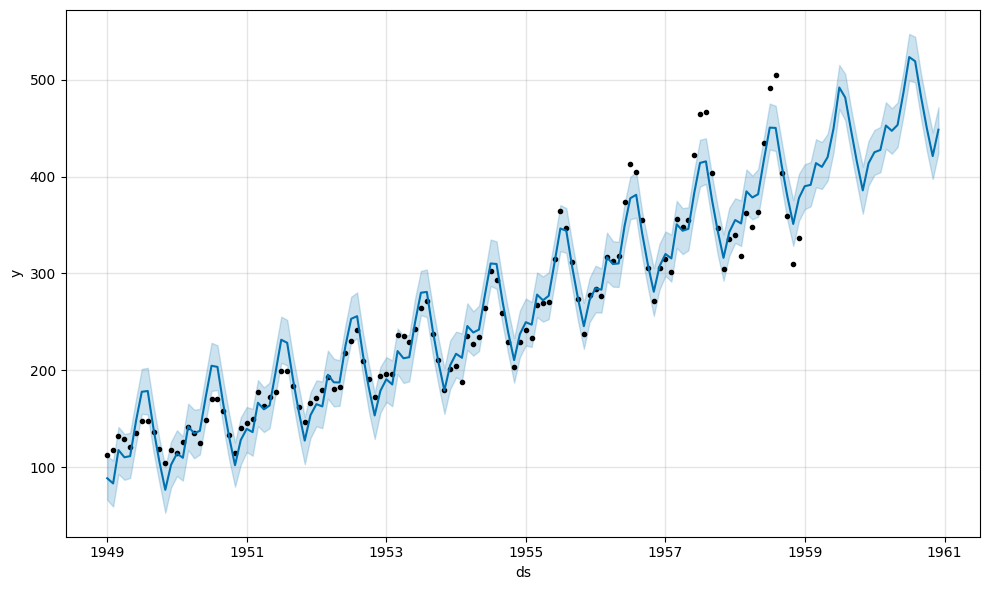

In [22]:
model.plot(forecast);

You can see that in addition to predictions, Prophet displays the lower and upper bounds of the confidence interval for these predictions. This interval takes into account the uncertainty due to past data variability and helps to better evaluate the risks associated with forecasts. You can access the prediction values and confidence interval bounds via the 'yhat', 'yhat_lower' and 'yhat_upper' columns of the forecast dataframe.

It is also possible to display the trend and seasonality of the time series with Prophet's plot_components function.

(j) Display the time series components.

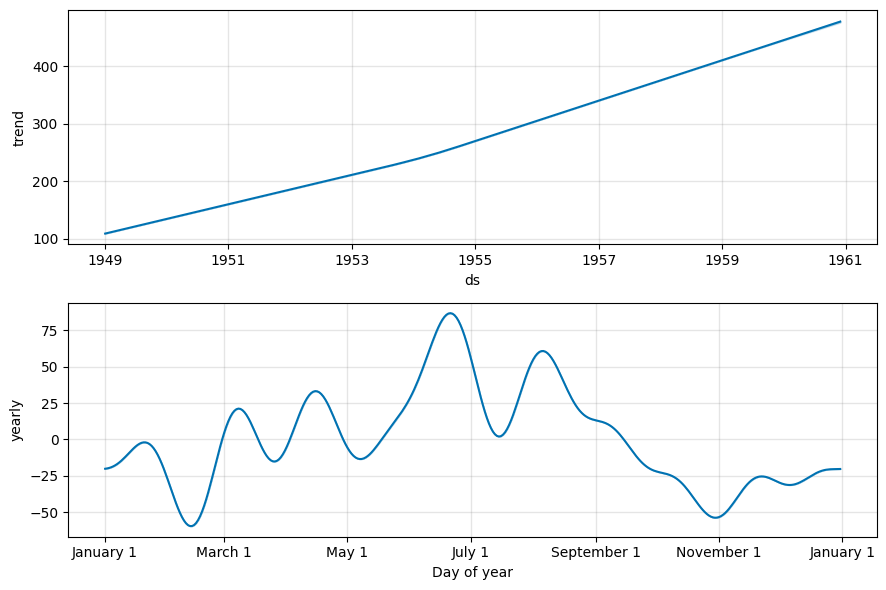

In [23]:
model.plot_components(forecast);

(k) Calculate and display the model's RMSE.

In [24]:
from sklearn.metrics import root_mean_squared_error

rmse = root_mean_squared_error(df_test['y'], forecast['yhat'].tail(24))
print(f'Root mean square error (RMSE): {rmse}')

Root mean square error (RMSE): 40.21577814863546


(l) Display model predictions and actual values on a graph.

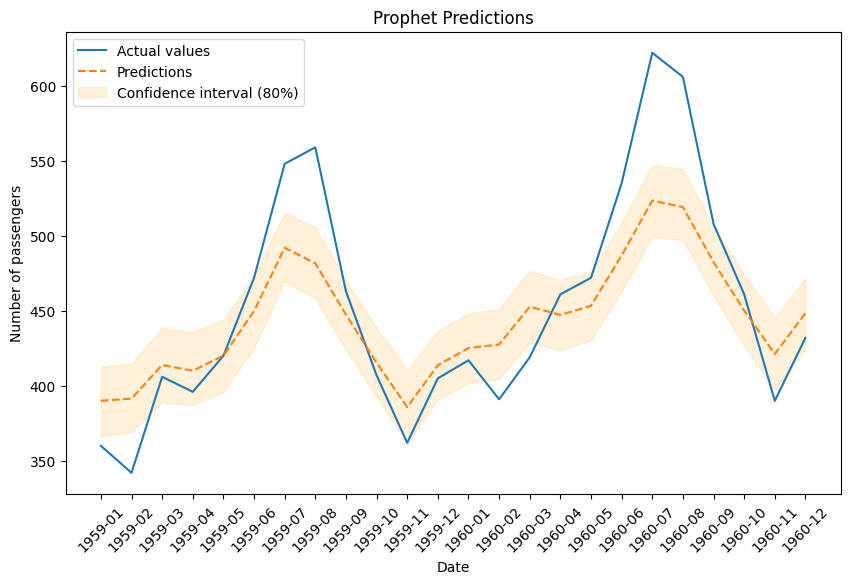

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(df_test['ds'], df['y'].tail(24), label='Actual values')
plt.plot(df_test['ds'], forecast['yhat'].tail(24), label='Predictions', linestyle='--')
plt.fill_between(df_test['ds'], forecast['yhat_lower'].tail(24), forecast['yhat_upper'].tail(24),
                 color='orange', alpha=0.15, label='Confidence interval (80%)')
plt.title('Prophet Predictions')
plt.xlabel('Date')
plt.xticks(df_test['ds'], rotation=45)
plt.ylabel('Number of passengers')
plt.legend()
plt.show()

### V. Hyperparameter Optimization

In the previous parts, we used Prophet to create models with default hyperparameters. However, to obtain better results, it may be necessary to optimize these hyperparameters. This is what we will do in this part.

In the Prophet documentation, it is suggested to optimize 5 hyperparameters:

- **changepoint_prior_scale**: It determines the flexibility of the trend, and particularly how much the trend
changes at trend changepoints. If it is too low, the trend will be underfitted and the variance that should have been modeled by trend changes will instead be handled by the noise term. If it is too high, the trend will be overfitted and in the most extreme case, you might end up with a trend equal to the annual seasonality. A range of [0.001, 0.5] is recommended, with a default value of 0.05.

- **seasonality_prior_scale**: This parameter controls the flexibility of seasonality. Similarly, a large value allows seasonality to adjust to large fluctuations, while a small value reduces the magnitude of seasonality. The default value is 10, and a reasonable range for adjustment is [0.01, 10].

- **holidays_prior_scale**: This controls the flexibility to adjust holiday effects. It has the same default value and recommended range as seasonality_prior_scale.

-**seasonality_mode**: It defines whether we have an additive or multiplicative model.

- **changepoint_range**: This is the proportion of training data in which the trend is allowed to change. This defaults to 0.8, which means the model will not adjust to trend changes in the last 20% of the time series. This prevents overfitting to trend changes at the very end of the time series where there isn't enough margin to properly adjust it.

For our time series, we have already seen in previous notebooks that the model was multiplicative so the seasonality_mode parameter will have the value 'multiplicative'. Moreover, we don't have data on holidays, so the holidays_prior_scale parameter will be useless.

Finally, we have a monthly series, so we will have parameters daily_seasonality=False, weekly_seasonality=False and yearly_seasonality=True.

(m) Create a dictionary param_fixed that contains the values of the parameters seasonality_mode, daily_seasonality, weekly_seasonality and yearly_seasonality.

In [26]:
param_fixed = {
    'seasonality_mode': 'multiplicative',
    'daily_seasonality': False,
    'weekly_seasonality': False,
    'yearly_seasonality': True
}

We will therefore seek to optimize the remaining parameters, namely changepoint_prior_scale, seasonality_prior_scale and changepoint_range. For this, we will measure the performance of several parameter combinations that will be validated using prophet's cross_validation function.

(n) Create a dictionary param_grid that contains the values to test for the parameters changepoint_prior_scale, seasonality_prior_scale and changepoint_range.

In [27]:
param_grid= {'changepoint_prior_scale': [0.01,0.1, 0.5],
             'seasonality_prior_scale': [0.1, 1.0, 10.0, 15],
             'changepoint_range': [0.5, 0.75, 0.95]}




Now that you have defined the parameters to test, all that remains is to measure the performance of different parameter combinations. For this, we will use Prophet's cross_validation function. This method works by dividing all the data into a series of training and test windows.

Initialization: You specify an initial training period (initial), which determines how much data will be used to train the model at the start.

Validation Period: From this training period, the model is tested at several intervals defined by the period parameter, where it predicts values for a horizon defined by the horizon parameter.

Predictions: Forecasts are made for each test window, allowing evaluation of model performance over specific periods of history.

Results: Cross-validation results include performance metrics (such as MAE, RMSE, etc.) that allow judging the quality of predictions on unseen data.

(o) Execute the following code cell to test hyperparameter combinations using cross-validation.

In [28]:
import itertools
import numpy as np
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

# Define fixed parameters (if any)
#param_fixed = {}  # Define any fixed parameters here, or leave empty if not needed


# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    model_cv = Prophet(**param_fixed, **params).fit(df_train)  # Fit model with given params
    df_cv = cross_validation(model_cv, initial='2920 days', period='365 days', horizon = '365 days', parallel="threads")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3z5do1k/k4rifrm8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3z5do1k/mbi8a0c2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82467', 'data', 'file=/tmp/tmpx3z5do1k/k4rifrm8.json', 'init=/tmp/tmpx3z5do1k/mbi8a0c2.json', 'output', 'file=/tmp/tmpx3z5do1k/prophet_modelgq9b0sb4/prophet_model-20250403135259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:52:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:52:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 1957-12-01 00:00:00 and 1957-12-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.thread.ThreadPoolExecutor object at 0x79b504d60550>
DEBUG:cmdstanpy:input tempfile: /t

(p) Display the results of different hyperparameter combinations.

In [29]:
#results
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
display(tuning_results)

#sorte rmse descending=false
tuning_results = tuning_results.sort_values('rmse', ascending=True)
display(tuning_results)

,changepoint_prior_scale,seasonality_prior_scale,changepoint_range,rmse
0,0.01,0.1,0.50,18.641327
1,0.01,0.1,0.75,29.631401
2,0.01,0.1,0.95,30.500539
3,0.01,1.0,0.50,18.477751
4,0.01,1.0,0.75,30.125797
5,0.01,1.0,0.95,27.996250
6,0.01,10.0,0.50,18.256255
7,0.01,10.0,0.75,29.855577
8,0.01,10.0,0.95,28.974741
9,0.01,15.0,0.50,18.525255


,changepoint_prior_scale,seasonality_prior_scale,changepoint_range,rmse
6,0.01,10.0,0.50,18.256255
3,0.01,1.0,0.50,18.477751
9,0.01,15.0,0.50,18.525255
0,0.01,0.1,0.50,18.641327
35,0.50,15.0,0.95,23.287275
26,0.50,0.1,0.95,23.451429
32,0.50,10.0,0.95,23.558229
29,0.50,1.0,0.95,24.667465
18,0.10,10.0,0.50,25.673490
21,0.10,15.0,0.50,25.832042


(q) Display the best hyperparameter combination and its score.

In [30]:
best_params = all_params[np.argmin(rmses)]
best_score = tuning_results['rmse'].min()
print(best_params)
print(best_score)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'changepoint_range': 0.5}
18.256255406254713


You can now train a model with these hyperparameters, which should give much better results than the default model used in the previous part.

(r) Train a model on df_train with the best hyperparameters found through cross-validation.
(s) Make predictions on the future dataset.

In [31]:
model_tuned = Prophet(**best_params, **param_fixed)
model_tuned.fit(df_train)
predictions_tuned = model_tuned.predict(future)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3z5do1k/0y5bn514.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3z5do1k/z71x5_os.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6309', 'data', 'file=/tmp/tmpx3z5do1k/0y5bn514.json', 'init=/tmp/tmpx3z5do1k/z71x5_os.json', 'output', 'file=/tmp/tmpx3z5do1k/prophet_model5niixmd2/prophet_model-20250403135309.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:53:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:53:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


(t) View graphs of the model's prediction and components.

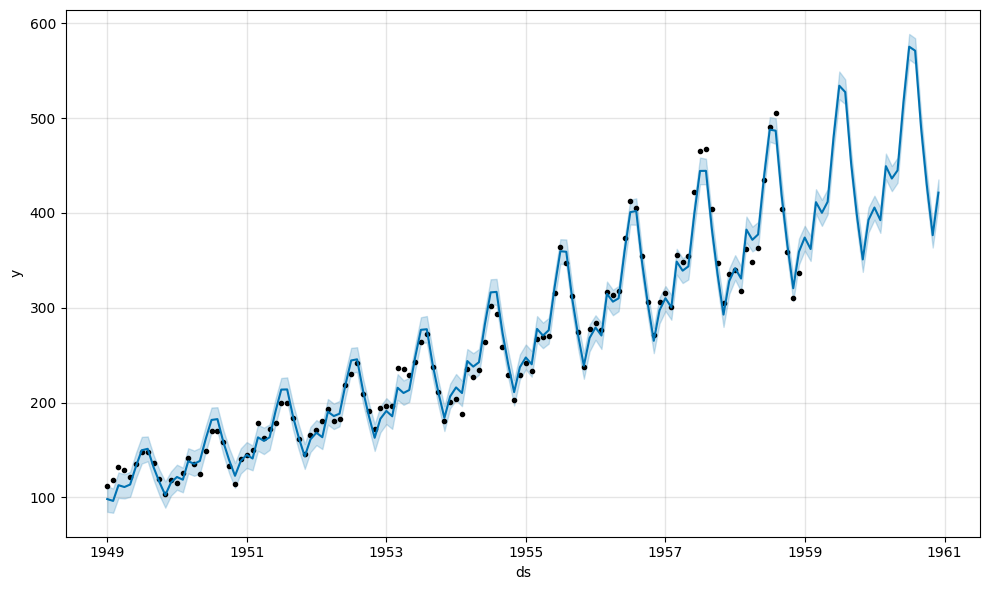

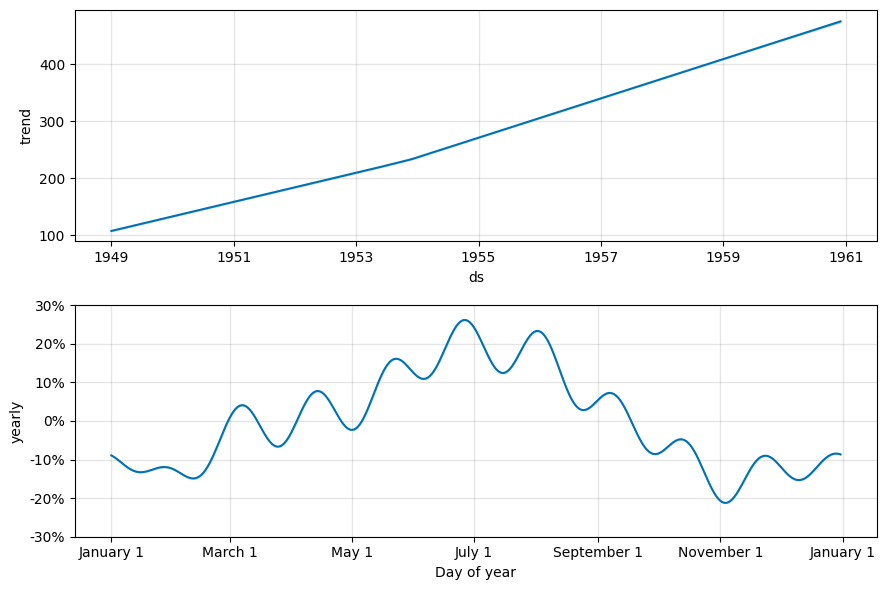

In [32]:
model_tuned.plot(predictions_tuned);
model_tuned.plot_components(predictions_tuned);

(u) Calculate and display the model's RMSE.

In [33]:
rmse = root_mean_squared_error(df_test['y'], predictions_tuned['yhat'].tail(24))
print(f'Root Mean Square Error (RMSE): {rmse}')

Root Mean Square Error (RMSE): 20.556524778230603


You can see that the RMSE has significantly decreased between the default model and the model with optimized hyperparameters.

(v) Display the model predictions and actual values on a graph.

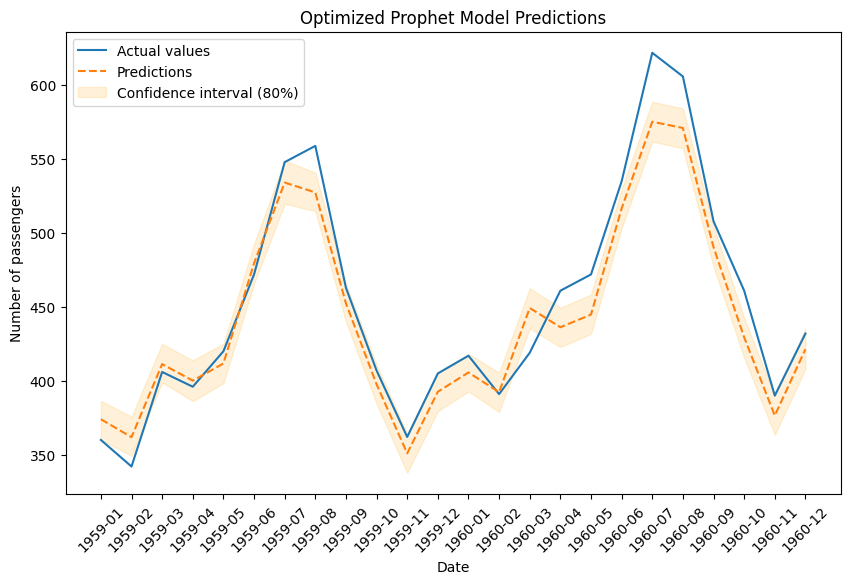

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(df_test['ds'], df['y'].tail(24), label='Actual values')
plt.plot(df_test['ds'], predictions_tuned['yhat'].tail(24), label='Predictions', linestyle='--')
plt.fill_between(df_test['ds'], predictions_tuned['yhat_lower'].tail(24), predictions_tuned['yhat_upper'].tail(24),
                 color='orange', alpha=0.15, label='Confidence interval (80%)')
plt.title('Optimized Prophet Model Predictions')
plt.xlabel('Date')
plt.xticks(df_test['ds'], rotation=45)
plt.ylabel('Number of passengers')
plt.legend()
plt.show()

# Task
Tell me about this dataset.

Here is all the data you need:
"AirPassengers.csv"

## Data loading

### Subtask:
Load the "AirPassengers.csv" dataset.


**Reasoning**:
Load the "AirPassengers.csv" dataset into a pandas DataFrame and display the first 5 rows.



In [35]:
import pandas as pd

try:
    df = pd.read_csv('AirPassengers.csv')
    display(df.head())
except FileNotFoundError:
    print("Error: 'AirPassengers.csv' not found.")
    df = None
except pd.errors.ParserError:
    print("Error: Could not parse 'AirPassengers.csv'. Check the file format.")
    df = None
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    df = None

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


## Data exploration

### Subtask:
Explore the loaded dataset to understand its characteristics.


**Reasoning**:
Explore the dataset by checking its shape, data types, descriptive statistics, missing values, and converting the 'Month' column to datetime if necessary.  Also, make some initial observations.



In [36]:
# Check the shape of the DataFrame
print("Shape of the DataFrame:", df.shape)

# Examine the data types of each column
print("\nData Types:\n", df.dtypes)

# Generate descriptive statistics for numerical columns
print("\nDescriptive Statistics:\n", df.describe())

# Check for missing values
print("\nMissing Values:\n", df.isnull().sum())

# Convert 'Month' column to datetime if it's not already
if not pd.api.types.is_datetime64_any_dtype(df['Month']):
    try:
        df['Month'] = pd.to_datetime(df['Month'])
    except ValueError as e:
        print(f"\nError converting 'Month' column to datetime: {e}")

# Display the updated DataFrame info
print("\nDataFrame Info:\n")
display(df.info())

# Initial observations
print("\nInitial Observations:")
print("The dataset appears to represent the number of air passengers over time.")
print("The 'Month' column has been converted to datetime format.")
print("There are no missing values.")
print("The distribution of passenger numbers might show seasonality.")

Shape of the DataFrame: (144, 2)

Data Types:
 Month          object
#Passengers     int64
dtype: object

Descriptive Statistics:
        #Passengers
count   144.000000
mean    280.298611
std     119.966317
min     104.000000
25%     180.000000
50%     265.500000
75%     360.500000
max     622.000000

Missing Values:
 Month          0
#Passengers    0
dtype: int64

DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


None


Initial Observations:
The dataset appears to represent the number of air passengers over time.
The 'Month' column has been converted to datetime format.
There are no missing values.
The distribution of passenger numbers might show seasonality.


## Data visualization

### Subtask:
Visualize the time series data of the number of air passengers over time.  Also, create a histogram and a box plot to understand the distribution of passenger numbers.


**Reasoning**:
Create the time series plot, histogram, and box plot as requested in the subtask.



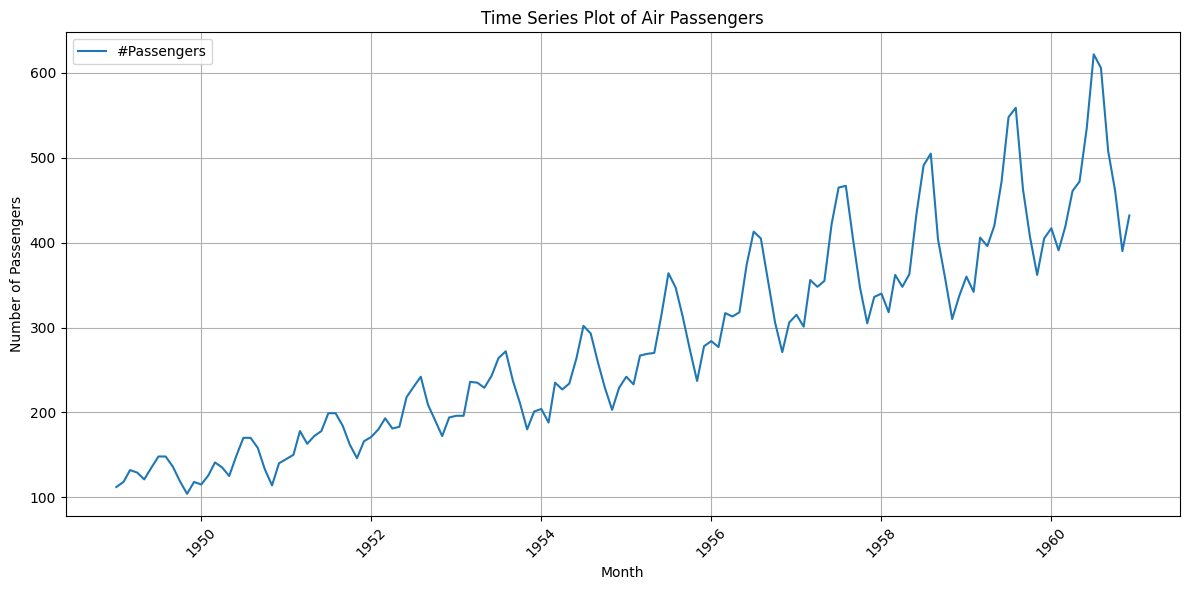

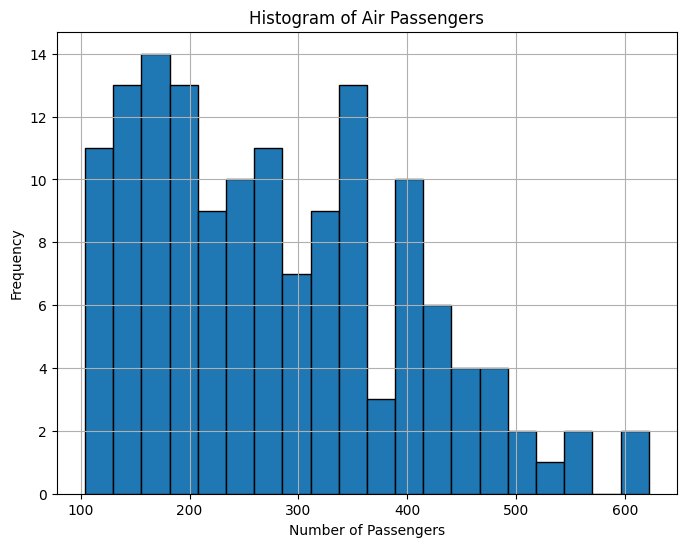

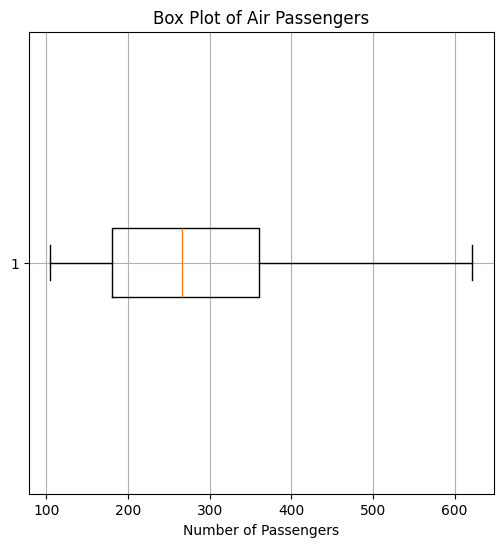

In [37]:
import matplotlib.pyplot as plt

# Time series plot
plt.figure(figsize=(12, 6))
plt.plot(df['Month'], df['#Passengers'], label='#Passengers')
plt.xlabel('Month')
plt.ylabel('Number of Passengers')
plt.title('Time Series Plot of Air Passengers')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Histogram
plt.figure(figsize=(8, 6))
plt.hist(df['#Passengers'], bins=20, edgecolor='black')
plt.xlabel('Number of Passengers')
plt.ylabel('Frequency')
plt.title('Histogram of Air Passengers')
plt.grid(True)
plt.show()

# Box plot
plt.figure(figsize=(6, 6))
plt.boxplot(df['#Passengers'], vert=False)
plt.xlabel('Number of Passengers')
plt.title('Box Plot of Air Passengers')
plt.grid(True)
plt.show()

## Data analysis

### Subtask:
Perform a statistical analysis of the time series data.


**Reasoning**:
Perform the statistical analysis as instructed, including calculating descriptive statistics, analyzing autocorrelation, decomposing the time series, and summarizing the findings.



Descriptive Statistics:
count    144.000000
mean     280.298611
std      119.966317
min      104.000000
25%      180.000000
50%      265.500000
75%      360.500000
max      622.000000
Name: #Passengers, dtype: float64


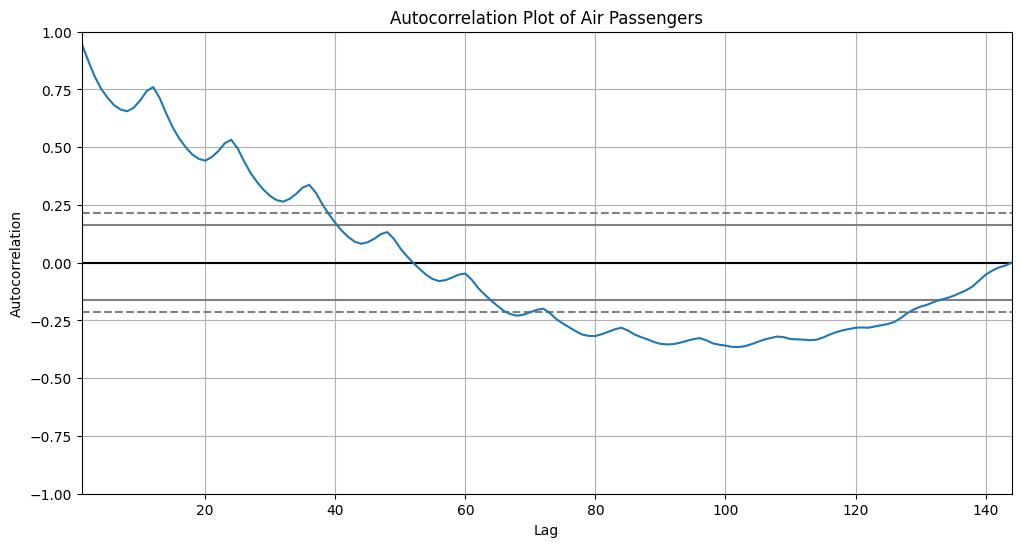

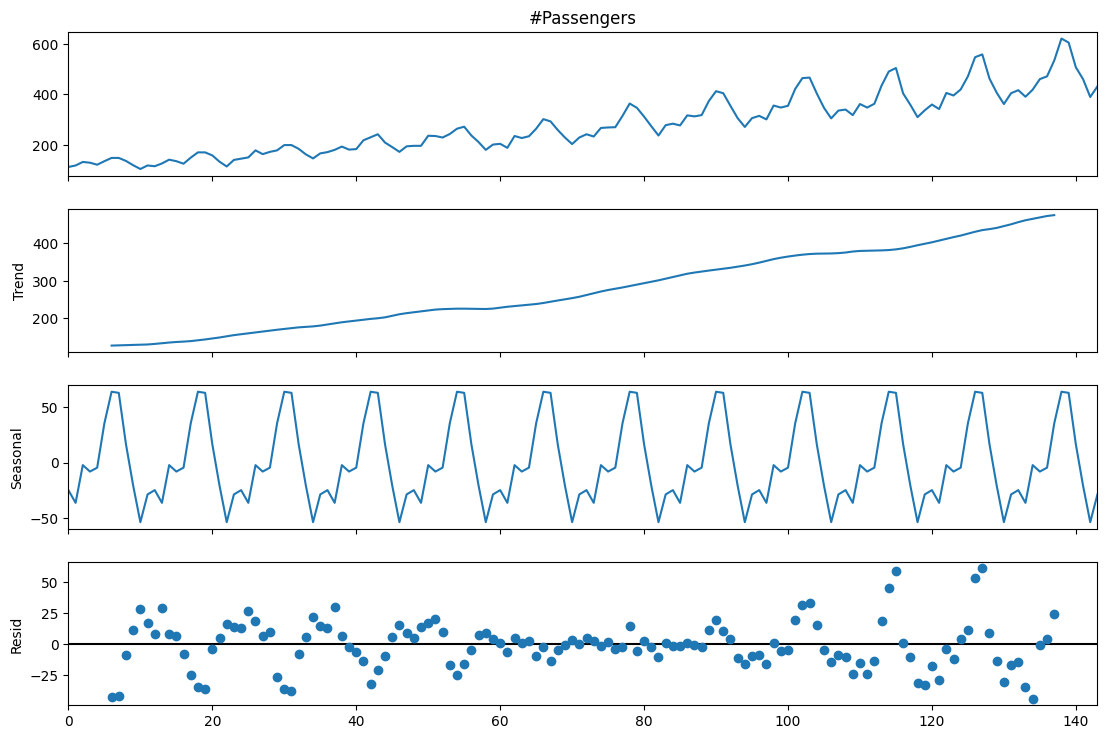


Summary of Statistical Analysis:
The descriptive statistics show the central tendency and dispersion of the passenger data.
The autocorrelation plot reveals potential seasonal patterns and correlations at various lags.
The time series decomposition illustrates the trend, seasonality, and residual components of the data.
Further analysis might be needed to quantify these patterns and build a predictive model.


In [38]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot

# 1. Descriptive statistics
print("Descriptive Statistics:")
print(df['#Passengers'].describe())

# 2. Autocorrelation analysis
plt.figure(figsize=(12, 6))
autocorrelation_plot(df['#Passengers'])
plt.title("Autocorrelation Plot of Air Passengers")
plt.show()

# 3. Time series decomposition
decomposition = seasonal_decompose(df['#Passengers'], model='additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

# 4. Summarize key findings
print("\nSummary of Statistical Analysis:")
print("The descriptive statistics show the central tendency and dispersion of the passenger data.")
print("The autocorrelation plot reveals potential seasonal patterns and correlations at various lags.")
print("The time series decomposition illustrates the trend, seasonality, and residual components of the data.")
print("Further analysis might be needed to quantify these patterns and build a predictive model.")

## Summary:

### 1. Q&A

No questions were asked in the provided text.


### 2. Data Analysis Key Findings

* **Data Characteristics:** The dataset contains 144 rows and 2 columns ('Month' and '#Passengers'). The 'Month' column was successfully converted to datetime format.  No missing values were found. The average number of passengers is approximately 280, with a standard deviation of about 120, indicating variability in passenger numbers (min: 104, max: 622).
* **Time Series Trend:**  The time series plot of air passengers shows an upward trend over time.
* **Passenger Distribution:** The histogram and box plot visualize the distribution of passenger numbers, highlighting the frequency and quartiles of the data, potentially revealing skewness or outliers.
* **Autocorrelation:** The autocorrelation plot suggests potential seasonal patterns and correlations at various lags in the passenger data, hinting at dependencies between observations at specific time intervals.
* **Time Series Decomposition:** Decomposition of the time series into trend, seasonality, and residuals (using an additive model with a period of 12) reveals underlying patterns in the data.


### 3. Insights or Next Steps

* **Seasonality Modeling:**  Further investigate the seasonality revealed by the autocorrelation and decomposition plots.  Develop a model that accounts for this seasonality to improve forecasting accuracy.
* **Trend Modeling:** Explore different trend modeling techniques to capture the upward trend in passenger numbers and project future growth.
